## 0. Import packages

In [1]:
import pandas as pd
import gzip
import math
from tqdm import tqdm
from itertools import chain, combinations
from Association import Association
from math import sqrt
tqdm.pandas() #for progres_apply etc.

## 1. Load data from previous step

In [2]:
seed_index = 0

In [3]:
import pickle
train_df = pickle.load(open(f"pickle_dumps/train_df_{seed_index}.p", "rb"))
tests_df = pickle.load(open(f"pickle_dumps/test_df_{seed_index}.p", "rb"))

article_train_df = pickle.load(open(f"pickle_dumps/article_train_df_{seed_index}.p", "rb"))
article_test_df = pickle.load(open(f"pickle_dumps/article_test_df_{seed_index}.p", "rb"))

In [4]:
train_df

,item_id,user_id
0,"[300, 924, 2877, 1588, 192, 35, 3596, 1531, 24...",0
1,"[5277, 1179, 1897, 141, 2825, 169, 1053, 1936,...",1
2,"[1206, 55, 323, 440, 58, 3946, 698, 54, 3106, ...",2
3,"[1198, 2839, 342, 2052, 332, 1132, 2512, 475, ...",3
4,"[2083, 126, 106, 2249, 345, 4934, 669, 1957, 0...",4
...,...,...
62977,[0],62977
62978,[3],62978
62979,[198],62979
62980,[14],62980


If we plot a disrtibution of the length per user, we see that most data leans towards a length of 100 items

34.33992251754469


(array([2.4807e+04, 1.4433e+04, 8.5120e+03, 5.1410e+03, 3.3080e+03,
        1.9260e+03, 1.1580e+03, 8.7100e+02, 6.1000e+02, 4.5800e+02,
        3.4300e+02, 2.5100e+02, 2.2100e+02, 1.6900e+02, 1.0000e+02,
        9.9000e+01, 7.7000e+01, 5.9000e+01, 5.6000e+01, 3.9000e+01,
        4.7000e+01, 4.9000e+01, 1.9000e+01, 2.5000e+01, 1.6000e+01,
        2.7000e+01, 1.7000e+01, 1.3000e+01, 7.0000e+00, 1.7000e+01,
        1.2000e+01, 9.0000e+00, 1.3000e+01, 7.0000e+00, 1.0000e+01,
        7.0000e+00, 3.0000e+00, 1.0000e+00, 7.0000e+00, 3.0000e+00,
        4.0000e+00, 2.0000e+00, 5.0000e+00, 9.0000e+00, 3.0000e+00,
        3.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00]),
 array([  1.  ,  15.24,  29.48,  43.72,  57.96,  72.2 ,  86.44, 100.68,
        114.92, 129.16, 143.4 , 157.64, 171.88, 186.12, 200.36, 214.6 ,
        228.84, 243.08, 257.32, 271.56, 285.8 , 300.04, 314.28, 328.52,
        342.76, 357.  , 371.24, 385.48, 399.72, 413.96, 428.2 , 442.44,
        456.68, 470.92, 485.16

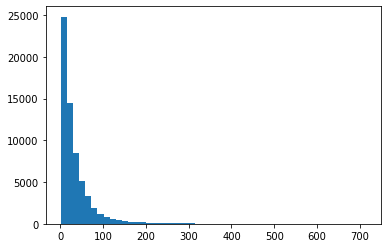

In [5]:
import matplotlib.pyplot as plt
x = [len(i) for i in train_df["item_id"]]
print(sum(x)/len(x))
plt.hist(x, bins=50)

In [6]:
article_train_df

,item_id,user_id
0,300,"[0, 7, 11, 17, 18, 23, 24, 32, 36, 49, 50, 65,..."
1,924,"[0, 3, 7, 16, 19, 20, 23, 24, 29, 42, 49, 69, ..."
2,2877,"[0, 4, 9, 27, 36, 49, 93, 95, 104, 133, 143, 1..."
3,1588,"[0, 10, 12, 13, 16, 20, 23, 32, 34, 39, 47, 49..."
4,192,"[0, 3, 10, 11, 12, 16, 17, 19, 20, 21, 24, 28,..."
...,...,...
7090,7163,[45058]
7091,7162,[50504]
7092,6679,[51768]
7093,6962,[52641]


The transposed dataframe that is used for building user association rules has only a few items most of the time. this is not that important because of the way user associations are build.

304.8339675828048


(array([6.389e+03, 3.150e+02, 1.280e+02, 7.100e+01, 4.400e+01, 2.300e+01,
        1.500e+01, 1.900e+01, 1.100e+01, 1.300e+01, 1.200e+01, 1.100e+01,
        5.000e+00, 5.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 2.000e+00,
        6.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([1.000000e+00, 5.818200e+02, 1.162640e+03, 1.743460e+03,
        2.324280e+03, 2.905100e+03, 3.485920e+03, 4.066740e+03,
        4.647560e+03, 5.228380e+03, 5.809200e+03, 6.390020e+03,
        6.970840e+03, 7.551660e+03, 8.132480e+03, 8.713300e+03,
        9.294120e+03, 9.874940e+03, 1.045576e+04, 1.103658e+04,
        1.161740e+04, 1.219822e+04, 1.277904e+04, 1.3359

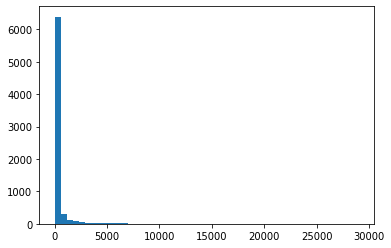

In [7]:
x = [len(i) for i in article_train_df["user_id"]]
print(sum(x)/len(x))
plt.hist(x, bins=50)

In [8]:
tests_df

,item_id,user_id
0,"[682, 561, 4927, 817, 217, 266, 53, 3062, 185,...",0
1,"[213, 1900, 4025, 1456, 3141, 1438, 1757, 459,...",1
2,"[2460, 1989, 1301, 1857, 2507, 104, 56, 215, 1...",2
3,"[681, 1804, 643, 729, 805, 915, 1029, 716, 193...",3
4,"[3, 1407, 1938, 540, 1006, 2205, 2291, 1746, 3...",4
...,...,...
62977,[2],62977
62978,[2],62978
62979,[5],62979
62980,[137],62980


In [9]:
data = train_df.set_index("user_id").to_dict()["item_id"]
article_data = article_train_df.set_index("item_id").to_dict()["user_id"]

test_users = tests_df["user_id"].tolist()

## 2. Functions or building association rules

In [10]:
# def eclat(prefix, minsup, items, start=True):
#     """
#     Basic eclat implementation for finding frequent itemsets
#     """
#     frequents = []
#     while items:
#         i,itids = items.pop()
#         isupp = len(itids)
#         if isupp >= minsup:
#             frequents.append((frozenset(prefix + [i]), isupp))
#             suffix = [] 
#             for j, ojtids in items:
#                 jtids = set(itids) & set(ojtids)
#                 if len(jtids) >= minsup:
#                     suffix.append((j,jtids))
#             frequents.extend(eclat(prefix+[i], minsup, sorted(suffix, key=lambda item: len(item[1]), reverse=True), False))
#     return frequents

In [11]:
# def subsets(itemset, include_empty_set=False):
#     """ List all strict subsets of an itemset without the empty set or with the empty set if include_empty_set=True
#         subsets({1,2,3}) --> [{1}, {2}, {3}, {1, 2}, {1, 3}, {2, 3}]
#     """
#     s = list(itemset)
#     if include_empty_set:
#         return map(set, chain.from_iterable(combinations(s, r) for r in range(0, len(s) + 1)))
#     return map(set, chain.from_iterable(combinations(s, r) for r in range(1, len(s))))

In [12]:
# def deriveRules(itemsets, minconf, test_users):
#     """ Returns all rules with conf >= minconf that can be derived from the itemsets.
#         Return: list of association rules in the format: [(antecedent, consequent, supp, conf), ...]
#     """
#     search_items = dict(itemsets)
#     rules = []
#     for item_set, supp in tqdm(itemsets):
#         if len(item_set) > 1: # itemsets with one frequent item are unable to generate a rule
#             for subset in subsets(item_set):  # for each subset generate a rule
#                 antecedent = frozenset(subset)
#                 consequent = item_set - subset
#                 if len(consequent)== 1: # only keep rules with one item in the consequent
#                     conf = supp / search_items[antecedent]
#                     if conf >= minconf: # assure confidence of the rule is high enough
#                         # if test_users are passed, only generate rules with one of the test users in the consequent
#                         if test_users:
#                             if list(consequent)[0] in test_users:
#                                 rules.append(Association(antecedent, consequent, conf, supp))
#                         else:
#                             rules.append(Association(antecedent, consequent, conf, supp))
                        

#     return rules

In [13]:
def convertTo(df):
    with open("eclat_in.txt", "w") as f:
        tmp = df.items()
        for item in tmp:
            s = ' '.join([str(elem) for elem in item[1]])
            f.write(s + "\n")
            

def convertFrom():
    res = []
    with open("eclat_out.txt", "r") as f:
        for line in f:
            try:
                tmp = line.strip()
                tmp = tmp.split(" <- ")
                consequent = [tmp[0]]
                tmp = tmp[1].split(" (")
                antecedent = tmp[0].split(" ")
                tmp = tmp[1].strip(')').split(", ")
                sup = tmp[0]
                conf = tmp[1]
                antecedent = list(map(int, antecedent))
                consequent = list(map(int, consequent))
                res.append(Association(antecedent, consequent, float(conf), float(sup)))
            except:
                pass
    
    return res

In [14]:
def genRules(min_conf, minsup, df):
    print("---writing data---")
    convertTo(df)
    print("---building rules---")
    !eclat.exe -tr -Z -s-$minsup -c$min_conf eclat_in.txt eclat_out.txt
    print("---reading data---")
    rules = convertFrom()

#     print("---Mining frequent itemsets---")
#     !eclat.exe -Z -s-200 eclat_in.txt eclat_out.txt
#     frequents = convertFrom()
#     print("---Generating rules---")
#     rules = deriveRules(frequents, min_conf, test_users)
    return rules 

#     print("---Mining frequent itemsets---")

#     frequent_itemsets = eclat([], minsup, sorted(data.items(), key=lambda item: len(item[1]), reverse=True))
#     print(f"{len(frequent_itemsets)} frequent itemsets")
#     c = 0
#     for f in frequent_itemsets:
#         if len(f[0]) == 1:
#             c += 1
#     print(f"{c} frequent itemsets of length 1")
#     print("---Generating rules---")
#     return deriveRules(frequent_itemsets, min_conf, test_users)

## 3. Build association rules

### Article association rules
Build rules of the form:
`Item1 and Item2 -> Item3`

In [15]:
%%time

print(len(data))

# Build the article association rules with a minimum support of 50 and minimum confidence of 0.85
article_assos_rules = []
values = [(0,1500), (80,200), (50,300), (25,400)]
for conf,sup in values:
    tmp = genRules(conf, sup, data)
    tmp = sorted(tmp, key=lambda x: x.s * x.c, reverse=True)[:1000000]
    article_assos_rules.extend(tmp)

62982
---writing data---
---building rules---


eclat.exe - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [7095 item(s), 62982 transaction(s)] done [0.11s].
filtering, sorting and recoding items ... [7095 item(s)] done [0.00s].
sorting and reducing transactions ... [60793/62982 transaction(s)] done [0.06s].
finding frequent item sets ... done [24.18s].
writing eclat_out.txt ... [36707169 rule(s)] done [10.86s].


all: 36707169
  0: 0
  1: 7095
  2: 1733333
  3: 13484816
  4: 16898345
  5: 4542686
  6: 40894
---reading data---
---writing data---
---building rules---
all: 20397
  0: 0
  1: 0
  2: 8
  3: 664
  4: 5486
  5: 9819
  6: 4191
  7: 227
  8: 2
---reading data---
---writing data---


eclat.exe - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [7095 item(s), 62982 transaction(s)] done [0.11s].
filtering, sorting and recoding items ... [1592 item(s)] done [0.00s].
sorting and reducing transactions ... [60690/62982 transaction(s)] done [0.04s].
finding frequent item sets ... done [46.04s].
writing eclat_out.txt ... [20397 rule(s)] done [0.76s].


---building rules---
all: 11694496
  0: 0
  1: 0---reading data---

  2: 6061
  3: 412891
  4: 2904269
  5: 5169896
  6: 2695240
  7: 484443
  8: 21549
  9: 147


eclat.exe - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [7095 item(s), 62982 transaction(s)] done [0.11s].
filtering, sorting and recoding items ... [1644 item(s)] done [0.01s].
sorting and reducing transactions ... [60703/62982 transaction(s)] done [0.04s].
finding frequent item sets ... done [52.41s].
writing eclat_out.txt ... [11694496 rule(s)] done [3.91s].


---writing data---
---building rules---
all: 27001268
  0: 0
  1: 9
  2: 47530
  3: 1780080
  4: 8757236
  5: 11425431
  6: 4449760
  7: 522755
  8: 18467
---reading data---


eclat.exe - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [7095 item(s), 62982 transaction(s)] done [0.11s].
filtering, sorting and recoding items ... [2042 item(s)] done [0.00s].
sorting and reducing transactions ... [60739/62982 transaction(s)] done [0.05s].
finding frequent item sets ... done [80.79s].
writing eclat_out.txt ... [27001268 rule(s)] done [9.07s].


Wall time: 9min 45s


In [16]:
len(article_assos_rules)

3020397

In [17]:
article_assos_rules = sorted(article_assos_rules, key=lambda x: x.s * x.c, reverse=True)[:1000000]

In [18]:
%%time

# print number of rules with item 3 in the lhs
counter = 0
for r in article_assos_rules:
    if 3 in r.left:
        counter += 1
counter

Wall time: 321 ms


152352

In [19]:
# print number of rules with a support greater than 150
for r in article_assos_rules:
    if int(r.s) > 10000:
        print(r)

Conf: 52.50	Supp: 28461.00	 {1} => {0}
Conf: 52.50	Supp: 28461.00	 {1} => {0}
Conf: 52.50	Supp: 28461.00	 {1} => {0}
Conf: 51.45	Supp: 29042.00	 {0} => {1}
Conf: 51.45	Supp: 29042.00	 {0} => {1}
Conf: 51.45	Supp: 29042.00	 {0} => {1}
Conf: 46.46	Supp: 28461.00	 {1} => {2}
Conf: 46.46	Supp: 28461.00	 {1} => {2}
Conf: 51.99	Supp: 25434.00	 {2} => {1}
Conf: 51.99	Supp: 25434.00	 {2} => {1}
Conf: 51.99	Supp: 25434.00	 {2} => {1}
Conf: 44.82	Supp: 29042.00	 {0} => {3}
Conf: 44.82	Supp: 29042.00	 {0} => {3}
Conf: 53.33	Supp: 24407.00	 {3} => {0}
Conf: 53.33	Supp: 24407.00	 {3} => {0}
Conf: 53.33	Supp: 24407.00	 {3} => {0}
Conf: 50.76	Supp: 25434.00	 {2} => {0}
Conf: 50.76	Supp: 25434.00	 {2} => {0}
Conf: 50.76	Supp: 25434.00	 {2} => {0}
Conf: 44.46	Supp: 29042.00	 {0} => {2}
Conf: 44.46	Supp: 29042.00	 {0} => {2}
Conf: 52.41	Supp: 24407.00	 {3} => {1}
Conf: 52.41	Supp: 24407.00	 {3} => {1}
Conf: 52.41	Supp: 24407.00	 {3} => {1}
Conf: 44.94	Supp: 28461.00	 {1} => {3}
Conf: 44.94	Supp: 28461.0

Conf: 17.83	Supp: 13155.00	 {13} => {26}
Conf: 23.43	Supp: 10013.00	 {26} => {13}
Conf: 18.58	Supp: 12620.00	 {14} => {65}
Conf: 17.83	Supp: 13155.00	 {13} => {34}
Conf: 14.43	Supp: 16245.00	 {7} => {67}
Conf: 12.03	Supp: 19484.00	 {4} => {64}
Conf: 18.83	Supp: 12450.00	 {15} => {68}
Conf: 18.15	Supp: 12911.00	 {2, 0} => {22}
Conf: 15.67	Supp: 14942.00	 {1, 0} => {43}
Conf: 8.05	Supp: 29042.00	 {0} => {105}
Conf: 22.08	Supp: 10594.00	 {22} => {36}
Conf: 21.64	Supp: 10799.00	 {21} => {32}
Conf: 9.19	Supp: 25434.00	 {2} => {102}
Conf: 18.23	Supp: 12791.00	 {3, 1} => {46}
Conf: 21.58	Supp: 10806.00	 {20} => {15}
Conf: 18.73	Supp: 12450.00	 {15} => {20}
Conf: 18.71	Supp: 12450.00	 {15} => {67}
Conf: 13.53	Supp: 17223.00	 {5} => {84}
Conf: 21.57	Supp: 10799.00	 {21} => {36}
Conf: 16.31	Supp: 14270.00	 {10} => {65}
Conf: 17.69	Supp: 13155.00	 {13} => {43}
Conf: 20.78	Supp: 11183.00	 {4, 1} => {32}
Conf: 20.75	Supp: 11183.00	 {4, 1} => {30}
Conf: 20.92	Supp: 11091.00	 {18} => {48}
Conf: 14.50

Conf: 18.04	Supp: 12094.00	 {16} => {27}
Conf: 13.63	Supp: 16003.00	 {8} => {51}
Conf: 13.63	Supp: 16003.00	 {8} => {86}
Conf: 15.63	Supp: 13953.00	 {11} => {44}
Conf: 13.42	Supp: 16245.00	 {7} => {74}
Conf: 12.65	Supp: 17223.00	 {5} => {79}
Conf: 16.73	Supp: 13016.00	 {3, 0} => {50}
Conf: 14.57	Supp: 14942.00	 {1, 0} => {42}
Conf: 12.63	Supp: 17223.00	 {5} => {69}
Conf: 20.78	Supp: 10458.00	 {4, 0} => {28}
Conf: 7.48	Supp: 29042.00	 {0} => {113}
Conf: 20.50	Supp: 10594.00	 {22} => {47}
Conf: 19.55	Supp: 11112.00	 {19} => {35}
Conf: 20.75	Supp: 10458.00	 {4, 0} => {35}
Conf: 17.43	Supp: 12450.00	 {15} => {70}
Conf: 19.53	Supp: 11112.00	 {19} => {53}
Conf: 19.40	Supp: 11183.00	 {4, 1} => {37}
Conf: 11.13	Supp: 19484.00	 {4} => {38}
Conf: 13.13	Supp: 16518.00	 {6} => {108}
Conf: 14.50	Supp: 14942.00	 {1, 0} => {50}
Conf: 19.49	Supp: 11112.00	 {19} => {45}
Conf: 17.39	Supp: 12450.00	 {15} => {61}
Conf: 19.51	Supp: 11091.00	 {18} => {63}
Conf: 13.31	Supp: 16245.00	 {7} => {83}
Conf: 19.47	

Conf: 11.97	Supp: 13155.00	 {13} => {59}
Conf: 11.04	Supp: 14270.00	 {10} => {102}
Conf: 6.19	Supp: 25434.00	 {2} => {98}
Conf: 13.01	Supp: 12094.00	 {16} => {36}
Conf: 5.42	Supp: 29042.00	 {0} => {152}
Conf: 14.56	Supp: 10799.00	 {21} => {91}
Conf: 14.14	Supp: 11112.00	 {19} => {58}
Conf: 15.02	Supp: 10458.00	 {4, 0} => {49}
Conf: 15.68	Supp: 10013.00	 {26} => {92}
Conf: 14.81	Supp: 10594.00	 {22} => {99}
Conf: 5.51	Supp: 28461.00	 {1} => {157}
Conf: 10.98	Supp: 14270.00	 {10} => {129}
Conf: 10.98	Supp: 14270.00	 {10} => {139}
Conf: 9.10	Supp: 17223.00	 {5} => {82}
Conf: 14.12	Supp: 11091.00	 {18} => {113}
Conf: 12.41	Supp: 12620.00	 {14} => {28}
Conf: 10.97	Supp: 14270.00	 {10} => {115}
Conf: 15.63	Supp: 10013.00	 {26} => {119}
Conf: 9.09	Supp: 17223.00	 {5} => {75}
Conf: 11.75	Supp: 13310.00	 {12} => {110}
Conf: 14.10	Supp: 11091.00	 {18} => {94}
Conf: 12.56	Supp: 12450.00	 {15} => {88}
Conf: 12.01	Supp: 13016.00	 {3, 0} => {88}
Conf: 12.38	Supp: 12620.00	 {14} => {97}
Conf: 6.40	Su

Conf: 11.90	Supp: 10603.00	 {24} => {120}
Conf: 7.64	Supp: 16518.00	 {6} => {185}
Conf: 12.60	Supp: 10013.00	 {26} => {76}
Conf: 12.07	Supp: 10447.00	 {3, 2} => {74}
Conf: 10.43	Supp: 12094.00	 {16} => {73}
Conf: 12.48	Supp: 10102.00	 {25} => {114}
Conf: 9.77	Supp: 12911.00	 {2, 0} => {107}
Conf: 6.47	Supp: 19484.00	 {4} => {192}
Conf: 7.76	Supp: 16245.00	 {7} => {142}
Conf: 5.17	Supp: 24407.00	 {3} => {196}
Conf: 12.59	Supp: 10013.00	 {26} => {140}
Conf: 11.52	Supp: 10945.00	 {17} => {70}
Conf: 7.87	Supp: 16003.00	 {8} => {152}
Conf: 11.67	Supp: 10799.00	 {21} => {141}
Conf: 12.57	Supp: 10013.00	 {26} => {49}
Conf: 12.05	Supp: 10447.00	 {3, 2} => {86}
Conf: 10.41	Supp: 12094.00	 {16} => {74}
Conf: 4.95	Supp: 25434.00	 {2} => {205}
Conf: 11.32	Supp: 11112.00	 {19} => {78}
Conf: 6.46	Supp: 19484.00	 {4} => {176}
Conf: 11.87	Supp: 10594.00	 {22} => {109}
Conf: 4.33	Supp: 29042.00	 {0} => {210}
Conf: 12.02	Supp: 10447.00	 {3, 2} => {62}
Conf: 4.94	Supp: 25434.00	 {2} => {176}
Conf: 9.82	S

Conf: 10.20	Supp: 10013.00	 {26} => {115}
Conf: 6.28	Supp: 16245.00	 {7} => {177}
Conf: 7.84	Supp: 13016.00	 {3, 0} => {95}
Conf: 9.32	Supp: 10945.00	 {17} => {111}
Conf: 9.32	Supp: 10945.00	 {17} => {134}
Conf: 7.00	Supp: 14578.00	 {9} => {205}
Conf: 6.37	Supp: 16003.00	 {8} => {125}
Conf: 3.51	Supp: 29042.00	 {0} => {276}
Conf: 10.18	Supp: 10013.00	 {26} => {213}
Conf: 9.17	Supp: 11112.00	 {19} => {104}
Conf: 7.30	Supp: 13953.00	 {11} => {151}
Conf: 7.97	Supp: 12791.00	 {3, 1} => {151}
Conf: 9.62	Supp: 10594.00	 {22} => {120}
Conf: 6.36	Supp: 16003.00	 {8} => {169}
Conf: 6.81	Supp: 14942.00	 {1, 0} => {153}
Conf: 5.91	Supp: 17223.00	 {5} => {153}
Conf: 9.61	Supp: 10594.00	 {22} => {115}
Conf: 7.74	Supp: 13155.00	 {13} => {114}
Conf: 9.10	Supp: 11183.00	 {4, 1} => {130}
Conf: 9.10	Supp: 11183.00	 {4, 1} => {141}
Conf: 6.16	Supp: 16518.00	 {6} => {226}
Conf: 10.08	Supp: 10102.00	 {25} => {120}
Conf: 7.29	Supp: 13953.00	 {11} => {108}
Conf: 9.59	Supp: 10603.00	 {24} => {163}
Conf: 6.16	

Conf: 6.21	Supp: 14578.00	 {9} => {117}
Conf: 3.18	Supp: 28461.00	 {1} => {308}
Conf: 5.25	Supp: 17223.00	 {5} => {133}
Conf: 3.55	Supp: 25434.00	 {2} => {268}
Conf: 6.95	Supp: 13016.00	 {3, 0} => {158}
Conf: 8.53	Supp: 10603.00	 {24} => {145}
Conf: 8.14	Supp: 11112.00	 {19} => {143}
Conf: 3.70	Supp: 24407.00	 {3} => {280}
Conf: 3.70	Supp: 24407.00	 {3} => {289}
Conf: 3.70	Supp: 24407.00	 {3} => {317}
Conf: 8.36	Supp: 10806.00	 {20} => {221}
Conf: 6.33	Supp: 14270.00	 {10} => {208}
Conf: 5.64	Supp: 16003.00	 {8} => {194}
Conf: 4.63	Supp: 19484.00	 {4} => {250}
Conf: 4.63	Supp: 19484.00	 {4} => {254}
Conf: 5.47	Supp: 16518.00	 {6} => {257}
Conf: 3.17	Supp: 28461.00	 {1} => {283}
Conf: 6.19	Supp: 14578.00	 {9} => {108}
Conf: 5.55	Supp: 16245.00	 {7} => {238}
Conf: 3.17	Supp: 28461.00	 {1} => {264}
Conf: 8.51	Supp: 10594.00	 {22} => {118}
Conf: 8.51	Supp: 10594.00	 {22} => {184}
Conf: 6.82	Supp: 13222.00	 {2, 1} => {158}
Conf: 3.55	Supp: 25434.00	 {2} => {169}
Conf: 4.62	Supp: 19484.00	 {

Conf: 4.05	Supp: 19484.00	 {4} => {322}
Conf: 5.54	Supp: 14270.00	 {10} => {296}
Conf: 5.29	Supp: 14942.00	 {1, 0} => {182}
Conf: 7.45	Supp: 10603.00	 {24} => {181}
Conf: 7.39	Supp: 10690.00	 {23} => {186}
Conf: 4.05	Supp: 19484.00	 {4} => {298}
Conf: 6.52	Supp: 12094.00	 {16} => {144}
Conf: 7.45	Supp: 10594.00	 {22} => {203}
Conf: 7.81	Supp: 10102.00	 {25} => {185}
Conf: 4.58	Supp: 17223.00	 {5} => {191}
Conf: 2.77	Supp: 28461.00	 {1} => {324}
Conf: 4.58	Supp: 17223.00	 {5} => {194}
Conf: 4.58	Supp: 17223.00	 {5} => {218}
Conf: 7.44	Supp: 10594.00	 {22} => {84}
Conf: 7.44	Supp: 10594.00	 {22} => {177}
Conf: 4.77	Supp: 16518.00	 {6} => {134}
Conf: 4.04	Supp: 19484.00	 {4} => {154}
Conf: 3.10	Supp: 25434.00	 {2} => {223}
Conf: 2.77	Supp: 28461.00	 {1} => {336}
Conf: 6.32	Supp: 12450.00	 {15} => {261}
Conf: 2.71	Supp: 29042.00	 {0} => {353}
Conf: 4.84	Supp: 16245.00	 {7} => {162}
Conf: 4.84	Supp: 16245.00	 {7} => {214}
Conf: 4.92	Supp: 16003.00	 {8} => {240}
Conf: 7.42	Supp: 10603.00	 {2

Conf: 2.57	Supp: 28461.00	 {1} => {384}
Conf: 4.43	Supp: 16518.00	 {6} => {227}
Conf: 4.43	Supp: 16518.00	 {6} => {268}
Conf: 6.77	Supp: 10799.00	 {21} => {202}
Conf: 6.77	Supp: 10799.00	 {21} => {240}
Conf: 5.87	Supp: 12450.00	 {15} => {298}
Conf: 6.68	Supp: 10945.00	 {17} => {151}
Conf: 6.90	Supp: 10594.00	 {22} => {237}
Conf: 5.79	Supp: 12620.00	 {14} => {254}
Conf: 6.58	Supp: 11112.00	 {19} => {191}
Conf: 4.57	Supp: 16003.00	 {8} => {298}
Conf: 5.53	Supp: 13222.00	 {2, 1} => {154}
Conf: 5.12	Supp: 14270.00	 {10} => {189}
Conf: 4.24	Supp: 17223.00	 {5} => {195}
Conf: 4.24	Supp: 17223.00	 {5} => {228}
Conf: 2.99	Supp: 24407.00	 {3} => {371}
Conf: 4.49	Supp: 16245.00	 {7} => {239}
Conf: 4.49	Supp: 16245.00	 {7} => {252}
Conf: 5.55	Supp: 13155.00	 {13} => {314}
Conf: 5.52	Supp: 13222.00	 {2, 1} => {166}
Conf: 4.42	Supp: 16518.00	 {6} => {319}
Conf: 6.58	Supp: 11091.00	 {18} => {220}
Conf: 5.65	Supp: 12911.00	 {2, 0} => {166}
Conf: 5.86	Supp: 12450.00	 {15} => {257}
Conf: 4.56	Supp: 160

Conf: 5.31	Supp: 12620.00	 {14} => {299}
Conf: 4.19	Supp: 16003.00	 {8} => {317}
Conf: 2.31	Supp: 29042.00	 {0} => {403}
Conf: 2.74	Supp: 24407.00	 {3} => {388}
Conf: 3.43	Supp: 19484.00	 {4} => {378}
Conf: 6.31	Supp: 10603.00	 {24} => {268}
Conf: 6.31	Supp: 10594.00	 {22} => {339}
Conf: 4.69	Supp: 14270.00	 {10} => {243}
Conf: 6.03	Supp: 11091.00	 {18} => {332}
Conf: 5.30	Supp: 12620.00	 {14} => {312}
Conf: 5.30	Supp: 12620.00	 {14} => {340}
Conf: 6.11	Supp: 10945.00	 {17} => {157}
Conf: 6.62	Supp: 10102.00	 {25} => {232}
Conf: 6.68	Supp: 10013.00	 {26} => {292}
Conf: 5.98	Supp: 11183.00	 {4, 1} => {230}
Conf: 6.19	Supp: 10806.00	 {20} => {124}
Conf: 5.05	Supp: 13222.00	 {2, 1} => {165}
Conf: 6.31	Supp: 10594.00	 {22} => {103}
Conf: 6.31	Supp: 10594.00	 {22} => {214}
Conf: 5.08	Supp: 13155.00	 {13} => {161}
Conf: 6.67	Supp: 10013.00	 {26} => {228}
Conf: 6.67	Supp: 10013.00	 {26} => {287}
Conf: 6.67	Supp: 10013.00	 {26} => {338}
Conf: 6.02	Supp: 11091.00	 {18} => {258}
Conf: 5.97	Supp:

Conf: 4.80	Supp: 13222.00	 {2, 1} => {179}
Conf: 4.83	Supp: 13155.00	 {13} => {166}
Conf: 5.88	Supp: 10799.00	 {21} => {257}
Conf: 5.88	Supp: 10799.00	 {21} => {274}
Conf: 4.45	Supp: 14270.00	 {10} => {258}
Conf: 4.45	Supp: 14270.00	 {10} => {280}
Conf: 3.26	Supp: 19484.00	 {4} => {417}
Conf: 2.60	Supp: 24407.00	 {3} => {408}
Conf: 4.76	Supp: 13310.00	 {12} => {303}
Conf: 4.76	Supp: 13310.00	 {12} => {359}
Conf: 4.35	Supp: 14578.00	 {9} => {236}
Conf: 5.24	Supp: 12094.00	 {16} => {168}
Conf: 5.79	Supp: 10945.00	 {17} => {153}
Conf: 5.79	Supp: 10945.00	 {17} => {174}
Conf: 5.09	Supp: 12450.00	 {15} => {340}
Conf: 4.82	Supp: 13155.00	 {13} => {135}
Conf: 5.71	Supp: 11112.00	 {19} => {201}
Conf: 5.71	Supp: 11112.00	 {19} => {258}
Conf: 5.87	Supp: 10799.00	 {21} => {299}
Conf: 4.24	Supp: 14942.00	 {1, 0} => {245}
Conf: 4.24	Supp: 14942.00	 {1, 0} => {260}
Conf: 6.27	Supp: 10102.00	 {25} => {228}
Conf: 6.27	Supp: 10102.00	 {25} => {251}
Conf: 5.08	Supp: 12450.00	 {15} => {357}
Conf: 5.97	Su

Conf: 4.26	Supp: 13953.00	 {11} => {282}
Conf: 5.94	Supp: 10013.00	 {26} => {200}
Conf: 5.94	Supp: 10013.00	 {26} => {309}
Conf: 4.17	Supp: 14270.00	 {10} => {156}
Conf: 5.32	Supp: 11183.00	 {4, 1} => {256}
Conf: 5.44	Supp: 10945.00	 {17} => {169}
Conf: 5.89	Supp: 10102.00	 {25} => {253}
Conf: 4.61	Supp: 12911.00	 {2, 0} => {191}
Conf: 3.45	Supp: 17223.00	 {5} => {319}
Conf: 5.70	Supp: 10447.00	 {3, 2} => {148}
Conf: 3.98	Supp: 14942.00	 {1, 0} => {278}
Conf: 3.45	Supp: 17223.00	 {5} => {290}
Conf: 3.45	Supp: 17223.00	 {5} => {297}
Conf: 3.45	Supp: 17223.00	 {5} => {311}
Conf: 3.45	Supp: 17223.00	 {5} => {346}
Conf: 5.50	Supp: 10806.00	 {20} => {119}
Conf: 5.50	Supp: 10806.00	 {20} => {95}
Conf: 5.50	Supp: 10806.00	 {20} => {344}
Conf: 4.16	Supp: 14270.00	 {10} => {379}
Conf: 4.46	Supp: 13310.00	 {12} => {376}
Conf: 3.98	Supp: 14942.00	 {1, 0} => {197}
Conf: 4.77	Supp: 12450.00	 {15} => {363}
Conf: 4.71	Supp: 12620.00	 {14} => {291}
Conf: 3.71	Supp: 16003.00	 {8} => {269}
Conf: 3.71	Su

Conf: 5.38	Supp: 10594.00	 {22} => {284}
Conf: 3.99	Supp: 14270.00	 {10} => {327}
Conf: 2.24	Supp: 25434.00	 {2} => {342}
Conf: 2.00	Supp: 28461.00	 {1} => {474}
Conf: 3.99	Supp: 14270.00	 {10} => {368}
Conf: 3.44	Supp: 16518.00	 {6} => {383}
Conf: 4.51	Supp: 12620.00	 {14} => {300}
Conf: 4.51	Supp: 12620.00	 {14} => {294}
Conf: 4.51	Supp: 12620.00	 {14} => {378}
Conf: 2.33	Supp: 24407.00	 {3} => {454}
Conf: 3.81	Supp: 14942.00	 {1, 0} => {261}
Conf: 5.45	Supp: 10447.00	 {3, 2} => {209}
Conf: 5.09	Supp: 11183.00	 {4, 1} => {164}
Conf: 4.57	Supp: 12450.00	 {15} => {294}
Conf: 4.57	Supp: 12450.00	 {15} => {355}
Conf: 4.27	Supp: 13310.00	 {12} => {348}
Conf: 4.27	Supp: 13310.00	 {12} => {370}
Conf: 4.33	Supp: 13155.00	 {13} => {191}
Conf: 5.68	Supp: 10013.00	 {26} => {324}
Conf: 4.70	Supp: 12094.00	 {16} => {196}
Conf: 4.37	Supp: 13016.00	 {3, 0} => {224}
Conf: 5.37	Supp: 10594.00	 {22} => {343}
Conf: 3.56	Supp: 16003.00	 {8} => {235}
Conf: 3.56	Supp: 16003.00	 {8} => {353}
Conf: 2.92	Sup

### User association rules
Build rules of the form: `User1 and User2 -> User3`

This builds rules that represent the relation and similarity between users.

In [20]:
%%time
# Build the user association rules with a minimum support of 40 and minimum confidence of 0.0
user_assos_rules = genRules(50,75,article_data)


---writing data---
---building rules---


eclat.exe - find frequent item sets with the eclat algorithm
version 5.22 (2020.06.15)        (c) 2002-2020   Christian Borgelt
reading eclat_in.txt ... [62982 item(s), 7095 transaction(s)] done [0.14s].
filtering, sorting and recoding items ... [18089 item(s)] done [0.01s].
sorting and reducing transactions ... [6730/7095 transaction(s)] done [0.02s].
finding frequent item sets ... done [97.38s].
writing eclat_out.txt ... [4103702 rule(s)] done [1.72s].


all: 4103702
  0: 0
  1: 0
  2: 52179
  3: 2301154
  4: 1268113
  5: 476671
  6: 5585
---reading data---
Wall time: 2min 9s


In [21]:
%%time

user_assos_rules = list(filter(lambda x: any([i in test_users for i in x.right]), user_assos_rules))

Wall time: 7.17 s


In [22]:
# print numebr of generated rules
print(len(user_assos_rules))

4103702


See for how much test users we were able to create association rules and how many

In [23]:
%%time

corr = {}
user_d = {}
for r in tqdm(user_assos_rules):
    for user in list(r.right):
        if user in corr:
            corr[user] += 1
            user_d[user].append(r)
        else:
            corr[user] = 1
            user_d[user] = [r]

100%|██████████| 4103702/4103702 [00:02<00:00, 1408270.40it/s]

Wall time: 3 s


In [24]:
for user in user_d:
    user_d[user] = sorted(user_d[user], key=lambda x: x.s * x.c, reverse=True)[:10000]

In [25]:
print(len(test_users))
print(len(corr))
print(corr)

62982
1403
{3: 70980, 0: 54092, 2: 56063, 5: 70574, 7: 10730, 1: 4371, 9: 1762, 4: 27084, 10: 43728, 11: 47913, 12: 76061, 13: 69301, 14: 5473, 17: 64190, 15: 65754, 16: 18174, 8: 116, 18: 68350, 19: 69455, 20: 15895, 23: 20457, 24: 494, 25: 1241, 6: 465, 27: 1065, 28: 64682, 29: 55794, 30: 37363, 31: 5721, 32: 55315, 33: 41643, 34: 11740, 37: 55, 36: 734, 35: 4336, 38: 57373, 39: 35896, 22: 1026, 41: 32753, 43: 9559, 42: 32136, 44: 13604, 45: 36303, 48: 12494, 47: 41347, 49: 5166, 51: 30144, 40: 252, 50: 26656, 26: 24380, 52: 24382, 53: 13040, 54: 16, 46: 14, 55: 25508, 56: 12661, 57: 1276, 59: 25429, 58: 616, 60: 1221, 61: 25092, 62: 12101, 63: 1614, 65: 40409, 66: 3728, 67: 22975, 68: 1804, 69: 5497, 72: 1969, 74: 21, 71: 129, 76: 646, 73: 30945, 75: 1208, 79: 36697, 80: 46985, 78: 1417, 81: 3037, 82: 313, 83: 797, 21: 28, 84: 20290, 86: 23052, 88: 248, 87: 1001, 90: 1207, 91: 8640, 92: 15358, 93: 24108, 96: 11549, 98: 4125, 97: 23929, 64: 838, 100: 5253, 102: 27907, 103: 19353, 104

In [26]:
total = 0
for u in user_d:
    total += len(user_d[u])
total

1891337

## 4. Normalize support / confidence to better use it later

In [27]:
"""
minc = 1
maxc = 0

mins = 9999999999999
maxs = -9999999999999
for a in article_assos_rules:
    if a.c < minc:
        minc = a.c
    if a.c > maxc:
        maxc = a.c
    
    if a.s < mins:
        mins = a.s
    if a.s > maxs:
        maxs = a.s
            
for a in article_assos_rules:
    a.c = (a.c - minc) / (maxc - minc)
    a.s = (a.s - mins) / (maxs - mins)
    # temp score that's just lhs + weighted average of c, s
    a.score = len(a.left) + sqrt(pow(a.c, 2) + pow(a.s, 2))

"""

# article_assos_rules = sorted(article_assos_rules, key = lambda x: x.score, reverse=True)
# for i in article_assos_rules[:20]:
#     print(i)


"\nminc = 1\nmaxc = 0\n\nmins = 9999999999999\nmaxs = -9999999999999\nfor a in article_assos_rules:\n    if a.c < minc:\n        minc = a.c\n    if a.c > maxc:\n        maxc = a.c\n    \n    if a.s < mins:\n        mins = a.s\n    if a.s > maxs:\n        maxs = a.s\n            \nfor a in article_assos_rules:\n    a.c = (a.c - minc) / (maxc - minc)\n    a.s = (a.s - mins) / (maxs - mins)\n    # temp score that's just lhs + weighted average of c, s\n    a.score = len(a.left) + sqrt(pow(a.c, 2) + pow(a.s, 2))\n\n"

## 5. Store the association rules as pickle file for further use

In [28]:
import pickle
pickle.dump(article_assos_rules, open("pickle_dumps/article_rules.p", "wb"))
pickle.dump(user_d, open("pickle_dumps/user_rules.p", "wb"))